# SIP Project

### Topic: Image Compression
### By:
### I007 Bhavya Bavishi
### I012 Nehaal Choudhary
### I020 Aum Ghag
### I038 Mohommed Arman Motiwala

### Importing Libraries

In [1]:
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)
import matplotlib.pyplot as plt
import scipy
import cv2

ModuleNotFoundError: No module named 'matplotlib'

In [ ]:
from numpy import pi
from numpy import sin
from numpy import zeros
from numpy import r_
from scipy import signal
from scipy import misc 
from scipy import fftpack
import math
import matplotlib.pylab as pylab
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)
DEBUG = False

### Reading Image as .png

Splitting into Red, Green, Blue channel

In [ ]:
im = cv2.imread("nature.png",1)
b,g,r= cv2.split(im)

The discrete cosine transform (DCT) represents an image as a sum of sinusoids of varying magnitudes and frequencies.

Function to find dct of each pixel

In [ ]:
def dct2(a):
    x =  scipy.fftpack.dct(scipy.fftpack.dct(a, axis=0, norm='ortho'), axis=1, norm='ortho' )
    return x

Creating arrays for R, G, B

In [ ]:
imsize = r.shape
dct_r = np.zeros(imsize)
dct_g = np.zeros(imsize)
dct_b = np.zeros(imsize)

Dividing the image into 8X8 matrix and finding dct of each pixel

In [ ]:
for i in r_[:imsize[0]:8]:
    for j in r_[:imsize[1]:8]:
        dct_r[i:(i+8),j:(j+8)] = dct2(r[i:(i+8),j:(j+8)] )
        dct_g[i:(i+8),j:(j+8)] = dct2(g[i:(i+8),j:(j+8)] )
        dct_b[i:(i+8),j:(j+8)] = dct2(b[i:(i+8),j:(j+8)] )

### Thresholding

Taking threshold as 0.03

Removing numbers less than threshold * max(color plane)

In [ ]:
thresh = 0.03

def thresholding(x):
    x =  x * (abs(x) > (thresh*np.max(x)))
    return x

Applying thresholding to each color channel

In [ ]:
dct_r = thresholding(dct_r)
dct_b = thresholding(dct_b)
dct_g = thresholding(dct_g)

In [ ]:
def run_len():
    i,j = 0,0
    up = True
    while True:
        yield (i,j)
        if i==j==7:
            break
        if up:
            if i==0 and j!=7:
                j+=1
                up = False
            elif j==7 and i!=7:
                i+=1
                up = False
            elif (j!=7 and i!=0):
                i-=1
                j+=1     
        else:
            if j==0 and i!=7:
                i+=1
                up = True
            elif i==7 and j!=7:
                j+=1
                up = True
            elif (j!=0 and i!=7):
                j-=1
                i+=1
    yield 0

In [ ]:
def compress_block(x):
    gen = run_len()
    old = None
    cnt=1
    # 0 padding on left and bottom
    y = np.zeros((8,8))
    y[:len(x),:len(x[0])] = x
    x = y
    # run-len encoding using the index returned by run_len generator.
    fin = []
    for i in range(8):
        for j in range(8):
            a,b = next(gen)
            num = int(x[a][b])
            if old != num:
                fin.append((old, cnt))
                cnt = 1
                old = num
            else:
                cnt+=1
    fin.append((old, cnt))
    # Removing the first data as it is initilized with None
    return fin[1:]

In [ ]:
def print_sample():
    print("Random 8X8 block\n")
    x = r[204:212, 204:212]
    print(x,'\n')

    print("DCT of the block which removes high frequency components\n")
    x = dct2(x)
    print(x,'\n')

    print("DCT after thresholding with thresholding at 0.03\n")
    x = thresholding(x)
    print(x,'\n')

    print("Run length coding output for the block")
    x = compress_block(x)
    print(x,'\n')
# if DEBUG:
print_sample()
# print("Doing run length coding")

Random 8X8 block

[[27 29 30 32 40 49 58 69]
 [26 27 28 29 34 40 48 56]
 [21 23 23 24 25 28 31 33]
 [18 18 19 19 20 22 25 25]
 [17 17 16 16 17 19 20 19]
 [17 17 16 15 16 17 18 18]
 [16 15 15 14 15 15 16 16]
 [14 14 14 14 14 15 15 15]] 

DCT of the block which removes high frequency components

[[188.5   -31.849  11.98   -2.118  -0.75   -1.183   0.179   0.35 ]
 [ 70.499 -32.541   9.737  -3.767   0.849  -1.856   0.41   -0.217]
 [ 27.792 -16.633   5.453  -2.021   1.386  -1.729   0.948  -0.023]
 [ 11.179  -7.232   3.772   0.402   0.274  -1.159   0.345   0.345]
 [  0.5    -3.738   0.096   0.571  -0.25    0.107   0.231  -0.256]
 [ -1.046   0.064  -0.555  -0.068   0.095   0.142   0.107   0.438]
 [ -1.5     1.66   -1.302   0.108  -0.574  -0.394  -0.203  -0.778]
 [ -2.208   1.874  -1.141   0.687  -0.266  -0.176  -0.218  -0.503]] 

DCT after thresholding with thresholding at 0.03

[[188.5   -31.849  11.98   -0.     -0.     -0.      0.      0.   ]
 [ 70.499 -32.541   9.737  -0.      0.     -0.   

Displaying frequency of each pixel value

High frequency part of the image is in the lower right part of the image (which has been removed)

Lower frequency of the image is in the upper left part of the image

Storing compressed values in each color channel

In [ ]:
red = []
green = []
blue = []
for i in r_[:imsize[0]:8]:
    r_block = []
    g_block = []
    b_block = []
    for j in r_[:imsize[1]:8]:
        r_block.append(compress_block(dct_r[i:(i+8),j:(j+8)]))
        g_block.append(compress_block(dct_g[i:(i+8),j:(j+8)]))
        b_block.append(compress_block(dct_b[i:(i+8),j:(j+8)]))
    red.append(r_block)
    green.append(g_block)
    blue.append(b_block)
    
# Converting array to string and removing "(", ")" and space.
print("Run length coding completed")

if DEBUG:
    with open("r.txt","w") as f:
        f.write(str(red).replace("(","").replace(")","").replace(" ",""))

red = str(red).replace("(","").replace(")","").replace(" ","")
green = str(green).replace("(","").replace(")","").replace(" ","")
blue = str(blue).replace("(","").replace(")","").replace(" ","")


Run length coding completed


### Huffman Encoding

Huffman Coding is a Lossless Compression Algorithm which is used in image and video compression.

In [ ]:
def compress_channel(channel_data, file_name):

    symbol_dict = {}
    class node:
        def __init__(self, freq, symbol, left=None, right=None):
            self.freq = freq
            self.symbol = symbol
            self.left = left
            self.right = right
            self.huff = ''

    def printNodes(node, val=''):
        newVal = val + str(node.huff)
        if(node.left):
            printNodes(node.left, newVal)
        if(node.right):
            printNodes(node.right, newVal)
        if(not node.left and not node.right):
            print(f"{node.symbol} -> {newVal}")
            symbol_dict[node.symbol] = newVal

    unique_char = set(channel_data)
    counter = {}
    for char in unique_char:
        counter[char] = channel_data.count(char)

    chars = [i for i in counter]
    freq = [counter[i] for i in counter]
    nodes = []
    total = sum(freq)
    for x in range(len(chars)):
        nodes.append(node(freq[x], chars[x]))
      
    while len(nodes) > 1:
        nodes = sorted(nodes, key=lambda x: x.freq)
        left = nodes[0]
        right = nodes[1]
        left.huff = 0
        right.huff = 1
        newNode = node(left.freq+right.freq, left.symbol+right.symbol, left, right)
        nodes.remove(left)
        nodes.remove(right)
        nodes.append(newNode)

    printNodes(nodes[0])
    temp = [[counter[i],i] for i in counter]
    temp.sort(reverse = True)
    Rx = sum([len(symbol_dict[i[1]])*(i[0]/total) for ind, i in enumerate(temp)])
    print("Rx", Rx)

    Hx = sum([(-i[0]/total)*(math.log(i[0]/total,2)) for ind, i in enumerate(temp)])
    print("Hx", Hx)
    print("n",Hx/Rx*100)
    print('\n\n')
    # Huffman encoding end.

    bin_str = ""
    for i in channel_data:
        bin_str += symbol_dict[i]

    # May loose the last byte. 
    # Making multiple of 8
    x = len(bin_str)%8
    if x!=0:
        bin_str += "0" * (8 - x)

    ch_code = bytes()
    for i in range(0, len(bin_str) - 1, 8):
        num = int(bin_str[i: i + 8], base=2)
        _chr = num.to_bytes(1, 'little')
        ch_code += _chr
    metadata[file_name] = [symbol_dict, len(ch_code)]
    if DEBUG:
        with open(file_name,"wb") as f:
            f.write(ch_code)
    return ch_code

### Storing file in .xyz format

In [ ]:
bytedata = bytes()
metadata = {}
metadata['imsize'] = imsize
metadata['thresh'] = thresh
bytedata += compress_channel(red, 'red')
bytedata += compress_channel(green, 'green')
bytedata += compress_channel(blue, 'blue')

print("metadata")
print(metadata)

bytedata = bytes(str(metadata).replace(" ",""), "ascii") + b'\x00' +bytedata

with open(f"image_{thresh}.xyz","wb") as f:
    f.write(bytedata)

6 -> 000
0 -> 001
4 -> 01000
2 -> 01001
7 -> 01010
8 -> 01011
[ -> 0110
] -> 0111
- -> 100000
9 -> 100001
5 -> 10001
3 -> 1001
1 -> 101
, -> 11
Rx 3.251547176997048
Hx 3.216678003831283
n 98.92761287880289



6 -> 000
0 -> 001
4 -> 01000
2 -> 01001
8 -> 01010
7 -> 01011
[ -> 0110
] -> 0111
1 -> 100
5 -> 10100
- -> 101010
9 -> 101011
3 -> 1011
, -> 11
Rx 3.249786971981006
Hx 3.215049556979986
n 98.9310863973387



6 -> 000
7 -> 00100
8 -> 00101
4 -> 00110
- -> 001110
9 -> 001111
0 -> 010
5 -> 01100
2 -> 01101
[ -> 0111
] -> 1000
3 -> 1001
1 -> 101
, -> 11
Rx 3.2212503495321796
Hx 3.1728282841174056
n 98.49679285492957



metadata
{'imsize': (1080, 1920), 'thresh': 0.03, 'red': [{'6': '000', '0': '001', '4': '01000', '2': '01001', '7': '01010', '8': '01011', '[': '0110', ']': '0111', '-': '100000', '9': '100001', '5': '10001', '3': '1001', '1': '101', ',': '11'}, 213444], 'green': [{'6': '000', '0': '001', '4': '01000', '2': '01001', '8': '01010', '7': '01011', '[': '0110', ']': '0111', 

Rx -> Average length of code word

Hx -> Entropy

n -> Efficiency of Huffman Encoding

Storing the data of the image in metadata to decompress it later

### Reading Binary File

In [ ]:
with open("image_0.03.xyz", "rb") as f:
    image_data = f.read()

for index, char in enumerate(image_data):
    if char == 0:
        break

### Processing Metadata

In [ ]:
metadata = image_data[:index]
metadata = metadata.decode("ascii")
data = eval(metadata)
red, green,blue = data['red'], data['green'], data['blue']
imsize = data['imsize']
thresh = data['thresh']

r_data = image_data[index+1: index+1 + red[1]]
g_data = image_data[index+1 + red[1]: index+1 + red[1] + green[1]]
b_data = image_data[index+1 + red[1] + green[1]: index+1 + red[1] + green[1] + blue[1]]

### Huffman Decoding with character table

Using the variable "symbol_dict" (symbol dictionary) obtained from huffman encoding to decode and bring back the original values.

In [ ]:
def huffman_decode(ch_data, symbol_dict):
    binary = ""
    symbol_dict = {symbol_dict[i]: i for i in symbol_dict}
    
    for i in ch_data:
        binary_num   = bin(i)[2:]
        binary_num = "0"*(8 - len(binary_num))+binary_num
        binary +=binary_num
    data = ""
    curr = ""
    for i in binary:
        curr+=i
        x = symbol_dict.get(curr,None)
        if x:
            curr=""
            data += x
    return data
    
r_matrix = huffman_decode(r_data, red[0])
g_matrix = huffman_decode(g_data, green[0])
b_matrix = huffman_decode(b_data, blue[0])

# remove garbage value. Values occuring after matrix
# ended because of 0 padding of byte.
# converts string to matrix 
r_matrix = eval(r_matrix.split("]]]")[0]+"]]]")
g_matrix = eval(g_matrix.split("]]]")[0]+"]]]")
b_matrix = eval(b_matrix.split("]]]")[0]+"]]]")

### Decompressing Image

In [ ]:
def run_len():
    i,j = 0,0
    up = True
    while True:
        yield (i,j)
        if i==j==7:
            break
        if up:
            if i==0 and j!=7:
                j+=1
                up = False
            elif j==7 and i!=7:
                i+=1
                up = False
            elif (j!=7 and i!=0):
                i-=1
                j+=1     
        else:
            if j==0 and i!=7:
                i+=1
                up = True
            elif i==7 and j!=7:
                j+=1
                up = True
            elif (j!=0 and i!=7):
                j-=1
                i+=1
    yield 0


In [ ]:
def decompress_block(x): 
    gen = run_len()
    index = 0
    num = x[0]
    max_cnt = x[1]
    cnt = 0
    y = np.zeros((8,8))

    for i in range(8):
        for j in range(8):
            a,b = next(gen)
            y[a][b] = num
            cnt+=1
            if (cnt == max_cnt and ((i,j) != (7,7))):
                cnt=0
                index +=2
                num = x[index]
                max_cnt = x[index + 1]
    return y


In [ ]:
def decode_channel(channel):
    fin = []
    for ind1, i in enumerate(channel):
        x = []
        for ind2, j in enumerate(i):
            x.append(decompress_block(j))
        x = np.concatenate(x, axis = 1)
        fin.append(x)
    fin = np.concatenate(fin, axis = 0)
    # trim extra bits
    fin = fin[:imsize[0],:imsize[1]]
    return fin

# Decompressing matrix with reverse run-length coding
r_channel = decode_channel(r_matrix)
g_channel = decode_channel(g_matrix)
b_channel = decode_channel(b_matrix)


### Taking Inverse Discrete Cosine Transform

In [ ]:
def idct2(a):
    return fftpack.idct(fftpack.idct( a, axis=0 , norm='ortho'), axis=1 , norm='ortho')

### Reconstructing Image

True

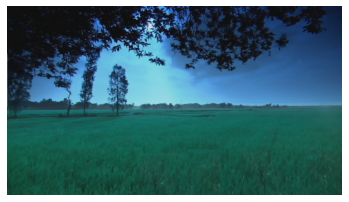

In [ ]:
for i in r_[:imsize[0]:8]:
    for j in r_[:imsize[1]:8]:
        r_channel[i:(i+8),j:(j+8)] = idct2( r_channel[i:(i+8),j:(j+8)] )
        g_channel[i:(i+8),j:(j+8)] = idct2( g_channel[i:(i+8),j:(j+8)] )
        b_channel[i:(i+8),j:(j+8)] = idct2( b_channel[i:(i+8),j:(j+8)] )

        
# Post processing to keep the pixel values b/w [0,255]    
x = cv2.merge((np.array(np.clip(b_channel, 0, 255), dtype= np.uint8),
              np.array(np.clip(g_channel, 0, 255), dtype= np.uint8),
              np.array(np.clip(r_channel, 0, 255), dtype= np.uint8)))


##Display the dct of that block

plt.imshow(x, cmap='turbo', vmin=0, vmax=255)
plt.axis('off')

cv2.imwrite(f'nature_compressed_{thresh}.png', x)

### Conclusion:
We used Discrete Cosine Transform to compress the image. The original image was of size 2.5 Mb and after running the program, taking the threshold as 0.03, the size of the compressed image reduced to 1.14 Mb.